# Building Neural Networks to Classify the ‘EMNIST Balanced’ Dataset

## 1. Indicating the Imported Packages and Libraries

In [53]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.utils.data
import torchvision
from torchvision import transforms

## 2. Loading the Dataset

In [2]:
# Sets the device the MLP runs on
device = 'cpu'

# Loading the data for the MLP:
# - Loads in the train and test set of the Balanced EMNIST dataset
train_set = torchvision.datasets.EMNIST(root='./',train=True,split='balanced', transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.EMNIST(root='./',train=False,split='balanced', transform = transforms.Compose([transforms.ToTensor()]))

# Loading the data for the CNN:
# - Loading the data from CSV files as DataFrames
train_data = pd.read_csv("emnist-balanced-train.csv", header=None)
test_data = pd.read_csv("emnist-balanced-test.csv", header=None)

## 3. Preprocessing the Data

In [3]:
# Preprocessing the data for the MLP: 
# - Creates a loader for the train and test set
# - This is created to iterate through the training data in certain increments
# - For the MLP the training data is fed into the model in batches of 20
train_loader = torch.utils.data.DataLoader(train_set,batch_size=20)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=18800)

# Preprocessing the data for the CNN: 
# - Separating the labels and pixel values in the datasets
x_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
x_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# 1. Converting pixel values to float32 and normalising them to the range [0, 1] for better model convergence
# 2. Applying one-hot encoding to the labels for categorical classification
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=47)
y_test = to_categorical(y_test, num_classes=47)

# Reshaping the input data to include a channel dimension, required for 2D convolutional layers
# Images are now represented as 28x28 pixels with a single color channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


## 4. Understanding and Visualising the Dataset

### 4.1. The Number of Samples in the Training and Testing Sets

In [4]:
# Reporting the number of samples in the training and test set
print("This the number of Samples in the training set",len(train_set))
print("This is the number of Samples in the testing set",len(test_set))

This the number of Samples in the training set 112800
This is the number of Samples in the testing set 18800


### 4.2. Visualising Samples from the Data 

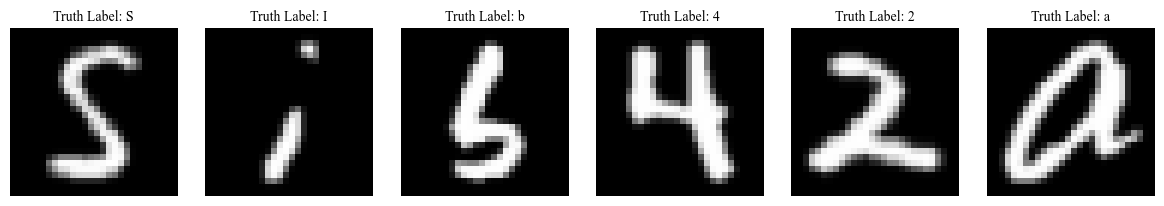

In [5]:
# Loading the text mapping file
# This creates a dictionary that maps numerical labels to their corresponding ASCII characters.
mapping_file = "emnist-balanced-mapping.txt"
mapping = {}
with open(mapping_file, "r") as file:
    for line in file:
        label, ascii_code = line.split()
        mapping[int(label)] = chr(int(ascii_code))

# Selecting a few samples randomly from the training data
num_samples_to_visualise = 6
sample_indices = np.random.randint(0, len(train_data), num_samples_to_visualise)
samples = train_data.iloc[sample_indices]

# Set the font for all plots
plt.rcParams['font.family'] = 'Times New Roman'

# Visualising the samples
fig, axes = plt.subplots(1, num_samples_to_visualise, figsize=(12, 3))
for i, (_, row) in enumerate(samples.iterrows()):
    label = row[0]  
    image = row[1:].values.reshape(28, 28) 
    # Flipping the images left to right
    image = np.fliplr(image)
    # Rotating the images 90 degrees anti-clockwise
    image = np.rot90(image)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title('Truth Label: ' + mapping[label], fontsize=10)
    axes[i].axis('off')

# Adjusting the spacing between the plots
plt.tight_layout(pad=2.0)

plt.show()

## 5. The Models

### 5.1. The MLP

#### 5.1.1. Creating the MLP

In [35]:
# Sets up our Neural Network as a class
class NeuralNetwork_Leaky_ReLU(nn.Module):
    # Initialise the neural network
    def __init__(self):
        super(NeuralNetwork_Leaky_ReLU, self).__init__()
        self.flattern = nn.Flatten()
        self.linear_leaky_relu_stack = nn.Sequential(
            # Input Layer:
            # - Takes in a flattend 2d vector representing an image of 28x28 pixels
            # - Converts the input into a 1d vector of length 512
            nn.Linear(28*28, 512),

            # Activation Function #1:
            # - LeakyRelU
            # - Allows NN to model non-linear relationships
            # - Takes output from current layer as input
            # - If input is positive, the leaky-ReLU will output that exact value
            # - If input is negative, it will apply a multiplier (0<) to give the value a small slope
            # - Unlike ReLU it stops neurons dying by giving small slops to negative inputs
            nn.LeakyReLU(),

            # Hidden Layer #1:
            # - This is a fully connected layer
            # - It is comprised of 512 neurons
            # - The neurons perform a linear transformation on the input data
            # - Each neuron recieves all values from the inputted sample
            # - Each neuron applies weights to each value in the sample
            # - A bias term is then added to each neuron weighted sum
            # - Input is a 1d vector of length 512
            # - Output is a 1d vector of length 512
            nn.Linear(512, 512),

            # Activation Function #2
            nn.LeakyReLU(),

            # Hidden Layer #2
            # - Performs the same as hidden layer #1
            nn.Linear(512, 512),

            # Activation Function #2
            nn.LeakyReLU(),

            # Hidden Layer #3
            # - Performs the same as hidden layers 1 and 2
            nn.Linear(512, 512),

            # Activation Function #3
            nn.LeakyReLU(),

            # Output layer
            # - It takes an input of a 1d vector of length 512
            # - Performs linear transformation on input
            # - Converts it into a 1d vector of length 47
            # - The output represents the 47 classes in the model
            # - The value associated with each of these 47 outputs is
            # - the probability the model thinks a given sample is of a certain class
            nn.Linear(512,47)
        )
        

    def forward(self,x):
        # Forward pass of the NN
        # Runs samples through the NN
        # Returns the a 1d vector of length 47
        # representing the probability of an input belonging to each class
        x = self.flattern(x)
        logits = self.linear_leaky_relu_stack(x)
        return logits

#### 5.1.2. Training the MLP

In [26]:
def MLP_Train(model,epochs,optimizer,criterion): 
    # Sets up variables to keep track of the loss and accuracy
    losses_list = []
    accuracy_list = []
    total_samples = 0
    correct_pred = 0

    # Iterates over the training loop of the NN for ith number of epochs
    for i in range(1,epochs+1):
        # Enumerates over the train_loader
        # Trains the model on batches of 20 samples
        for j,(images,targets) in enumerate(train_loader):
            # The model makes predictions on the training data
            y_pred = model(images)
            # Gives the predicted value from the model
            # The predicted is the largest probability from the 47 long output vector
            _, predicted = torch.max(y_pred, 1)
            # Calculates the loss of the model
            loss = criterion(y_pred,targets.reshape(-1))
            # Backpropagates through the model
            # The weight and biases are updated to reduce the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # A pieceWiseConstant learning rate
        # After the 5th epoch the learning rate of the model is set to 0.005
        if i>5:
            optimizer.lr = 0.0005
        # Calculates the loss and accuracy of the epoch
        total_samples += targets.size(0)
        correct_pred += (predicted == targets).sum().item()
        accuracy = correct_pred/total_samples
        loss_value = loss.item()
        print("this is the loss",loss_value,"for epoch",i)
        print("this is the accuracy",accuracy,"for epoch",i)
        losses_list.append(loss_value)
        accuracy_list.append(accuracy)
    # When the model has run ith epochs, the loss and accuracy of each epoch is returned
    # as well as the number of epochs
    EVAL = losses_list, accuracy_list, epochs
    return EVAL

# Initialise's the variable 'model' as the NeuralNetwork_Leaky_ReLU()
model = NeuralNetwork_Leaky_ReLU()
# Calls the training function
# Set the model to be the NeuralNetwork_Leaky_ReLU()
# Sets the optimizer to be Adagrad
# Sets initial learning rate to be 0.005
# Weight_decay = 0.0001, sets up L2 regularization
# criterion = nn.CrossEntropyLoss(), sets the loss function of the model to be Cross Entropy
start_time = time.time()
EVAL = MLP_Train(model,epochs=15,
                optimizer=torch.optim.Adagrad(model.parameters(),lr=0.005,weight_decay=0.0001),
                criterion=nn.CrossEntropyLoss())
end_time = time.time()
training_time = end_time-start_time
print("The model took",training_time/60,"minutes")
                                         

this is the loss 0.8685755729675293 for epoch 1
this is the accuracy 0.7 for epoch 1
this is the loss 0.623495876789093 for epoch 2
this is the accuracy 0.75 for epoch 2
this is the loss 0.5208555459976196 for epoch 3
this is the accuracy 0.7833333333333333 for epoch 3
this is the loss 0.45993852615356445 for epoch 4
this is the accuracy 0.8 for epoch 4
this is the loss 0.41783490777015686 for epoch 5
this is the accuracy 0.82 for epoch 5
this is the loss 0.39853960275650024 for epoch 6
this is the accuracy 0.8333333333333334 for epoch 6
this is the loss 0.38658666610717773 for epoch 7
this is the accuracy 0.8428571428571429 for epoch 7
this is the loss 0.3712848126888275 for epoch 8
this is the accuracy 0.85 for epoch 8
this is the loss 0.3592076897621155 for epoch 9
this is the accuracy 0.8555555555555555 for epoch 9
this is the loss 0.345508873462677 for epoch 10
this is the accuracy 0.86 for epoch 10
this is the loss 0.33045947551727295 for epoch 11
this is the accuracy 0.863636363

#### 5.1.3. Plotting the MLP Training Loss and Accuracy

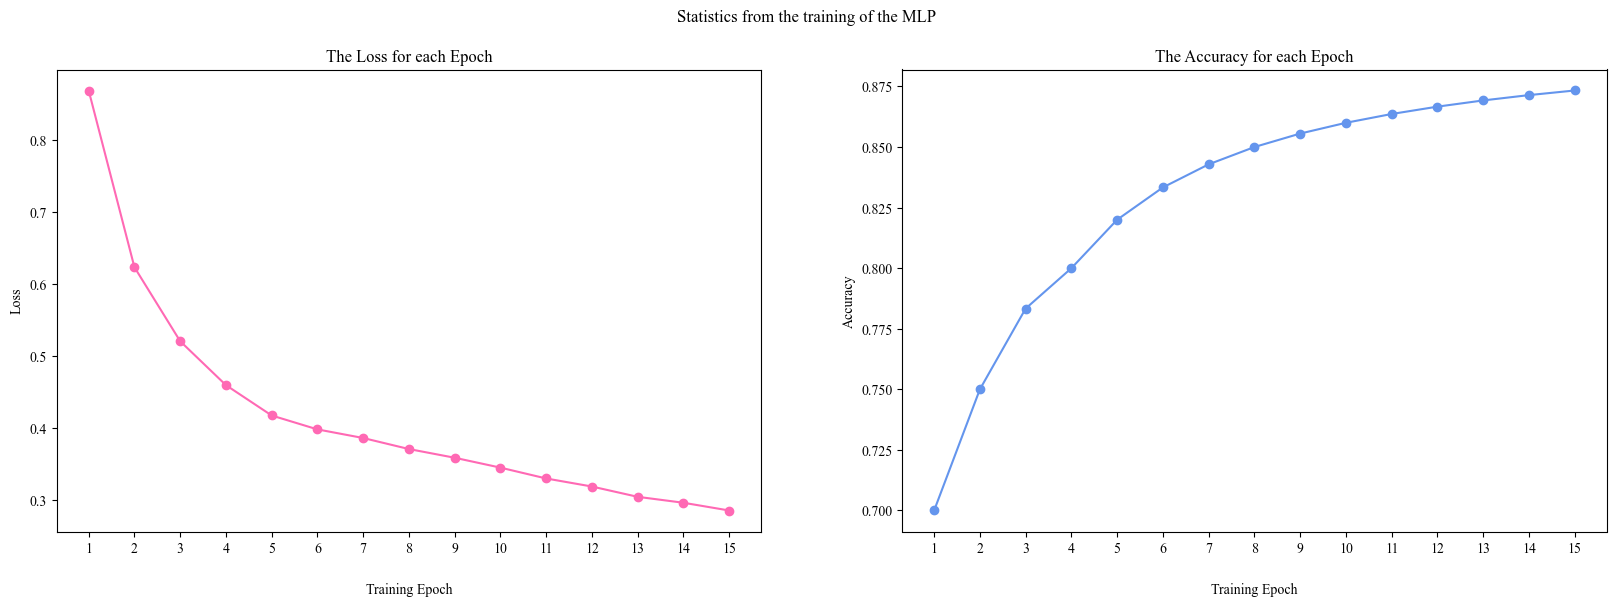

In [36]:
# Creating a list of epoch numbers for plotting
epochs_num = range(1, EVAL[2] + 1)

# Assigning training loss values for plotting
loss_points = EVAL[0]

# Assigning training accuracy values for plotting
accuracy_points = EVAL[1]

# Plotting the graphs
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_num, loss_points, color = "hotpink", marker = 'o')
plt.title("The Loss for each Epoch")
plt.xlabel("Training Epoch", labelpad=20)
plt.xticks(epochs_num)
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_num, accuracy_points, color = "cornflowerblue", marker = 'o')
plt.title("The Accuracy for each Epoch")
plt.xlabel("Training Epoch", labelpad=20)
plt.xticks(epochs_num)
plt.ylabel("Accuracy")

plt.suptitle("Statistics from the training of the MLP")
plt.show()

#### 5.1.4. Analysing the Results of the MLP Test

In [37]:
def testing_accuracy(model, data_loader):
    # Puts the model in evaluation mode
    # This disables certain layers like dropout and batch norm
    # This is to fairly test the model
    model.eval()
    test_loss = 0
    device = 'cpu'

    y_pred = []
    y_actu = []
    # Disables gradient calculation
    with torch.no_grad():
        # Iterates through batches of the data_loader (test_loader)
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            # Runs test data through NN
            # Makes predictions on test data
            output = model(data)
            # Calculates the summed loss of each batch
            test_loss += F.cross_entropy(output, target, reduction='sum').item() 
            # Gets the predicted class of input from the output of the NN
            pred = output.argmax(dim=1, keepdim=True)
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())
    # Copies of the flatten list of actual and predicted values
    # used to make confusion matrix
    predicted = y_pred
    actual = y_actu    
    y_pred = pd.Series(y_pred, name='Actual')
    y_actu = pd.Series(y_actu, name='Predicted')
    # Creates a confusion matrix of the predicted and actual values
    cm = pd.crosstab(y_actu, y_pred)
    # Calculates the correct prediction bt iterating through coordinates (i,i) in the confusion matrix
    correct = sum([cm.iloc[i,i] for i in range(len(cm))])
    # Calculates accuracy and loss for the training data
    test_loss /= len(data_loader.dataset)
    accuracy = 100*correct/len(data_loader.dataset)

    return(test_loss, accuracy, cm, predicted, actual)

#### 5.1.5. Printing the Test Loss and Accuracy

In [38]:
# Runs the MLP testing data through our trained model
test_results = testing_accuracy(model,test_loader)
print("- Test Loss: ", test_results[0], "\n")
print("- Accuracy: ", test_results[1], "\n")
# Stores accuracy for plotting later
accuracy_MLP = test_results[1]

- Test Loss:  0.47334462267287236 

- Accuracy:  85.03191489361703 



#### 5.1.6. Visualising Six Samples with Predicted Labels

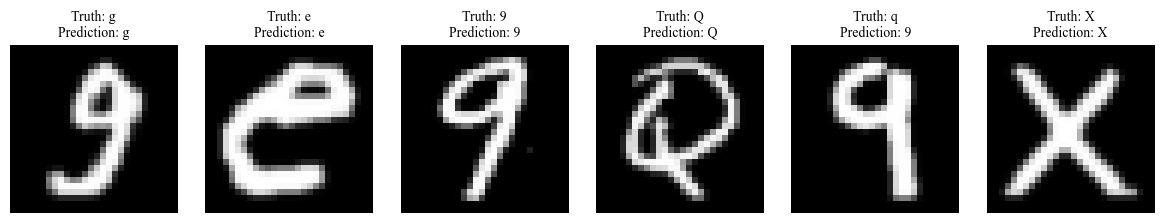

In [39]:
# Selecting the top samples from the testing dataset
num_samples_to_visualise = 6
sample_indices = range(num_samples_to_visualise)
sample_pred = test_results[3][0:num_samples_to_visualise]
sample_actu = test_results[4][0:num_samples_to_visualise]

# Visualising the samples
fig, axes = plt.subplots(1, num_samples_to_visualise, figsize=(12, 3))
for i in sample_indices:
    label = sample_actu[i]
    # Reshaping the 1d vector back into an image
    image = (x_test[i]).reshape(28,28)
    # Flipping the image
    image = np.fliplr(image)
    image = np.rot90(image)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Truth: {mapping[label]}\nPrediction: {mapping[sample_pred[i]]}", fontsize=10)
    axes[i].axis('off')
plt.tight_layout(pad=2.0)
plt.show()

#### 5.1.7. Printing the Confusion Matrix for the MLP Test (by label number)

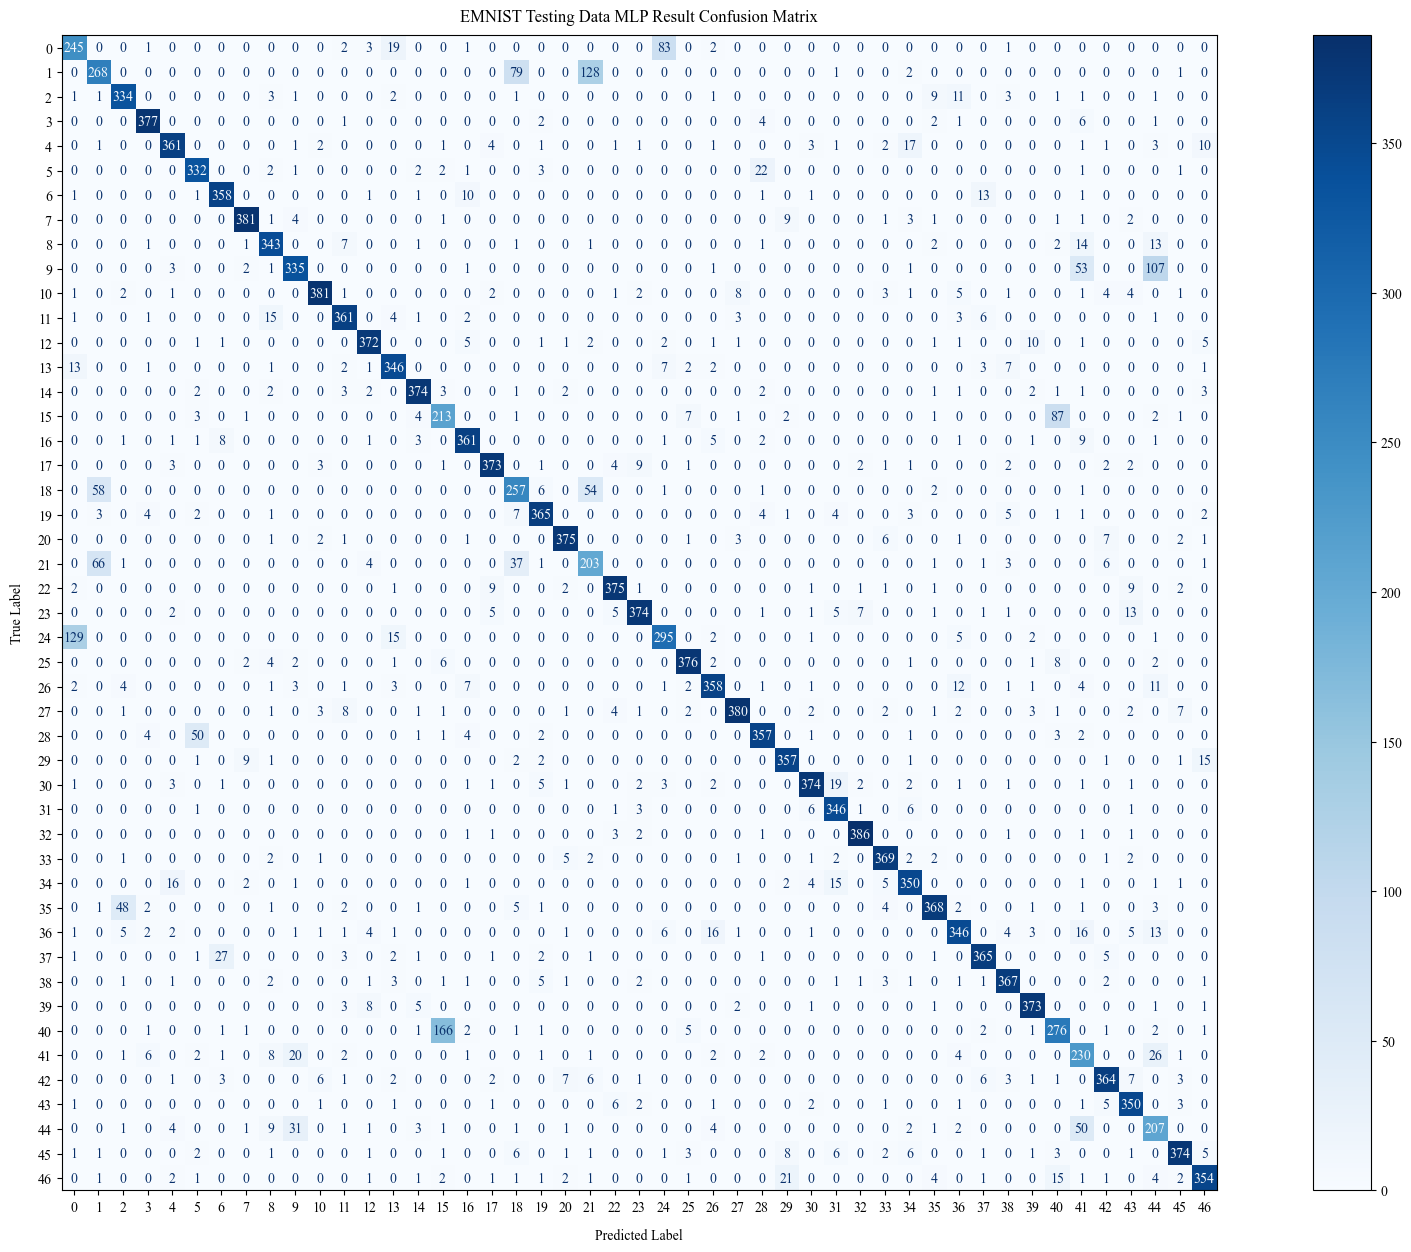

In [54]:
# Making the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_results[3], test_results[4])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
fig, ax = plt.subplots(figsize=(25, 15))
cm_display.plot(cmap = plt.cm.Blues, ax=ax)
plt.title("EMNIST Testing Data MLP Result Confusion Matrix", pad='10')
plt.grid(False)

# Adding padding to x and y axis labels
ax.set_xlabel("Predicted Label", labelpad=10)
ax.set_ylabel("True Label", labelpad=10)

plt.show()

#### 5.1.8. Printing the Confusion Matrix for the MLP Test (by character)

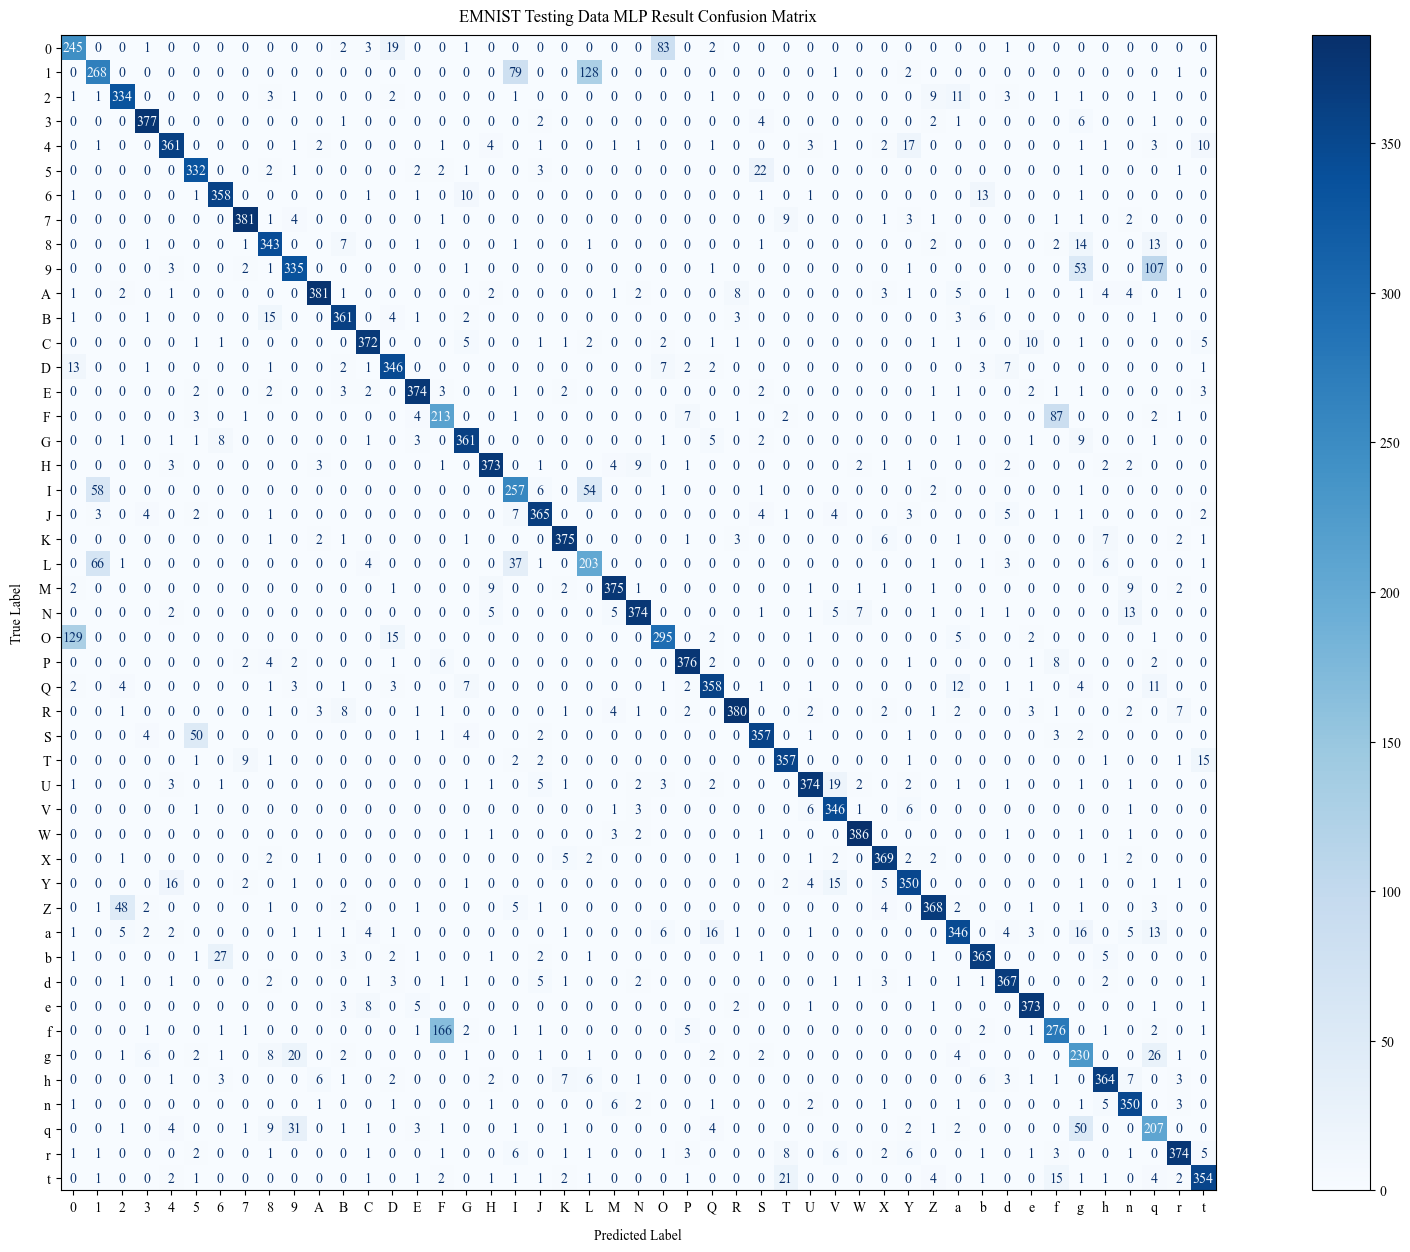

In [55]:
# Getting the characters for the axis labels
test_label_list = []
for key in mapping:
    test_label_list.append(mapping[key])

# Making the confusion matrix.
confusion_matrix = metrics.confusion_matrix(test_results[3], test_results[4])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=test_label_list)
fig, ax = plt.subplots(figsize=(25, 15))
cm_display.plot(cmap = plt.cm.Blues, ax=ax)
plt.title("EMNIST Testing Data MLP Result Confusion Matrix", pad='10')

# Adding padding to x and y axis labels
ax.set_xlabel("Predicted Label", labelpad=10)
ax.set_ylabel("True Label", labelpad=10)

plt.show()

#### 5.1.9. Reporting Recall, Accuracy and F1-score for the MLP Test

In [41]:
# Using Sklearn calculates the precision, recall and f1-score of the MLP
precision_MLP = precision_score(test_results[3], test_results[4], average='weighted')
recall_MLP = recall_score(test_results[3], test_results[4], average='weighted')
f1_MLP = f1_score(test_results[3], test_results[4], average='weighted')


### 5.2. The CNN

#### 5.2.1. Creating the CNN

In [15]:
# Defining the optimiser for training the neural network
# Here, the Adam optimiser with a learning rate of 0.0005 is used
# Adam is an adaptive learning rate optimisation algorithm that is often well-suited for image classification tasks

learning_rate = 0.0005
adam_optimizer = Adam(learning_rate=learning_rate)

# Defining model architecture using the Keras Sequential API
# This model utilises a combination of convolutional, max pooling, dropout, and dense layers

model = Sequential([
    # Convolutional Layer 1:
    # - 32 filters of size 3x3
    # - ReLU activation for non-linearity, efficiency and avoiding vanishing gradients
    # - 'same' padding ensures output feature maps have the same spatial dimensions as input
    # - Input shape is defined as 28x28 pixel images with 1 color channel
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    
    # Max Pooling Layer 1:
    # - Downsamples feature maps by taking the maximum value over 2x2 regions
    # - Reduces spatial dimensions and helps prevent overfitting
    MaxPooling2D((2, 2)),
    
    # Dropout Layer 1:
    # - Randomly drops out 25% of neurons during training to prevent overfitting 
    # - Forces the network to learn more robust features 
    Dropout(0.25),
    
    # Convolutional Layer 2:
    # - 64 filters of size 3x3
    # - ReLU activation
    # - 'same' padding
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    # Convolutional Layer 3:
    # - 64 filters of size 3x3
    # - ReLU activation
    # - 'same' padding
    # - Additional convolutional layer to learn more complex features 
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    # Max Pooling Layer 2:
    # - Further downsampling 
    MaxPooling2D((2, 2)),
    
    # Dropout Layer 2:
    # - Randomly drops out 25% of neurons
    Dropout(0.25),
    
    # Flatten Layer:
    # - Converts the 2D feature maps into a 1D vector for input to the fully connected layers
    Flatten(),
    
    # Dense (Fully Connected) Layer 1:
    # - 512 neurons
    # - ReLU activation
    Dense(512, activation='relu'),
    
    # Dropout Layer 3: 
    # - Randomly drops out 50% of neurons
    # - Higher dropout rate to further prevent overfitting in the fully connected layers 
    Dropout(0.5),
    
    # Output Layer:
    # - 47 neurons corresponding to the 47 character classes in the EMNIST dataset
    # - Softmax activation to output class probabilities
    Dense(47, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### 5.2.2. Training the CNN

In [16]:
# Compiling the model, configuring the learning process
model.compile(
    loss='categorical_crossentropy',  # Loss function: measures difference between predictions and true labels
    optimizer=adam_optimizer,  # Optimiser: Adam with a learning rate of 0.0005 for efficient weight updates
    metrics=['accuracy']  # Metrics: tracks the percentage of correct predictions during training
)

# Training the model and taking the time it takes to train it

# Recording the starting time
start = time.time()

# Training the model for 10 epochs with validation data
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test)) 

# Recording ending time
end = time.time() 

# Calculating and printing the training duration
print("The training time for the CNN was", (end-start), "seconds") 

# Extracting training loss and accuracy in each epoch for further analysis
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

Epoch 1/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 245s 69ms/step - accuracy: 0.6287 - loss: 1.2801 - val_accuracy: 0.8608 - val_loss: 0.4031
Epoch 2/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 240s 68ms/step - accuracy: 0.8393 - loss: 0.4660 - val_accuracy: 0.8728 - val_loss: 0.3584
Epoch 3/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 248s 70ms/step - accuracy: 0.8597 - loss: 0.3967 - val_accuracy: 0.8791 - val_loss: 0.3404
Epoch 4/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 239s 68ms/step - accuracy: 0.8715 - loss: 0.3550 - val_accuracy: 0.8839 - val_loss: 0.3374
Epoch 5/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 239s 68ms/step - accuracy: 0.8774 - loss: 0.3336 - val_accuracy: 0.8859 - val_loss: 0.3149
Epoch 6/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 267s 76ms/step - accuracy: 0.8844 - loss: 0.3125 - val_accuracy: 0.8876 - val_loss: 0.3145
Epoch 7/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 283s 80ms/step - accuracy: 0.8883 - loss: 0.3015 - val_accuracy: 0.8889 - val_loss: 0.3197
Epoch 8/10
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 271s 77ms/step - accuracy: 

#### 5.2.3. Plotting the CNN Training Loss and Accuracy

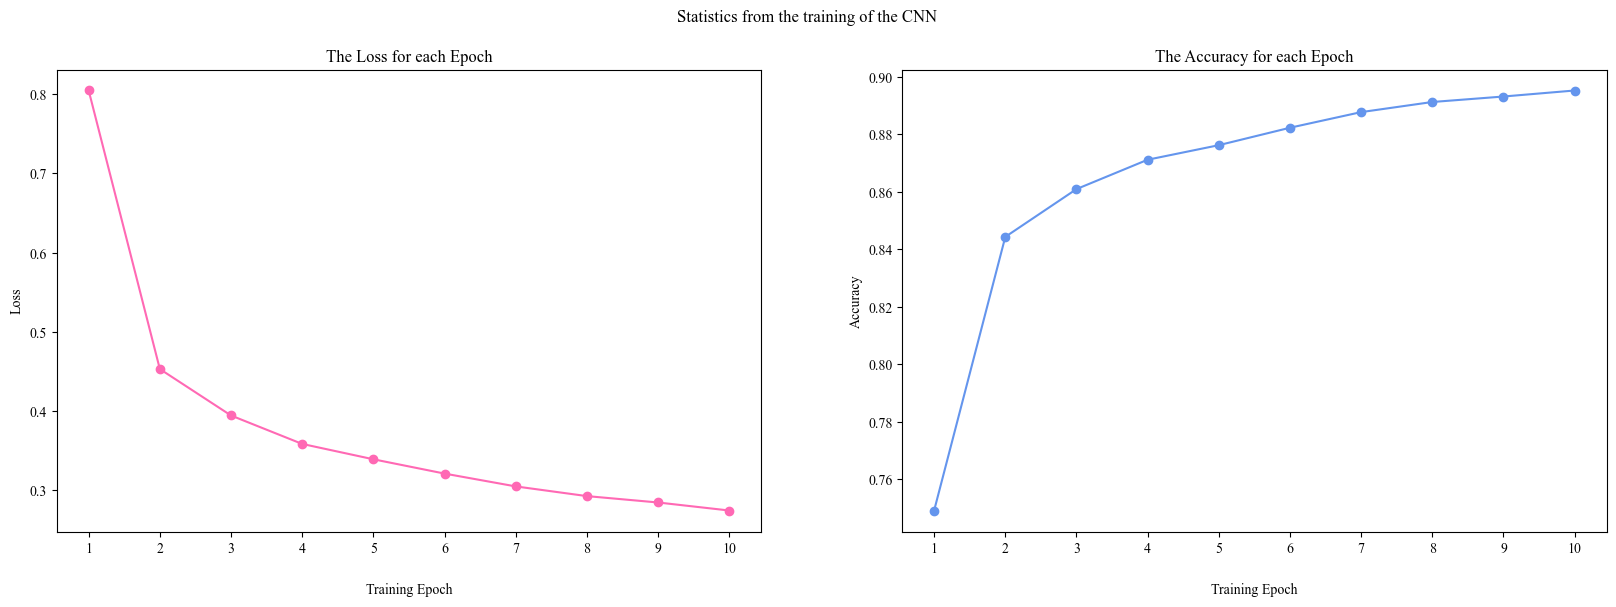

In [17]:
# Creating a list of epoch numbers for plotting
epochs = range(1, len(training_loss) + 1)

# Assigning training loss values for plotting
loss_points = training_loss

# Assigning training accuracy values for plotting
accuracy_points = training_accuracy

# Plotting the graphs
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_points, color = "hotpink", marker = 'o')
plt.title("The Loss for each Epoch")
plt.xlabel("Training Epoch", labelpad=20)
plt.xticks(epochs)
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_points, color = "cornflowerblue", marker = 'o')
plt.title("The Accuracy for each Epoch")
plt.xlabel("Training Epoch", labelpad=20)
plt.xticks(epochs)
plt.ylabel("Accuracy")

plt.suptitle("Statistics from the training of the CNN")
plt.show()

#### 5.2.5. Printing the Test Loss and Accuracy

In [18]:
# Evaluating the model with test data, and getting the loss and accuracy
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3104589879512787
Test accuracy: 0.8936170339584351


#### 5.2.6. Predicting Each Class in the Testing Dataset

In [19]:
# Making predictions on the test set and extracting predicted and true classes

# Generating predictions (probabilities for each class) for the test set
predicted_probabilities = model.predict(x_test)

# Getting the predicted class for each sample (index of the highest probability)
predicted_classes = predicted_probabilities.argmax(axis=1)

# Getting the true class labels for each sample from the one-hot encoded y_test data
true_classes = y_test.argmax(axis=1)

588/588 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


#### 5.2.7. Visualising Six Samples with Predicted Labels

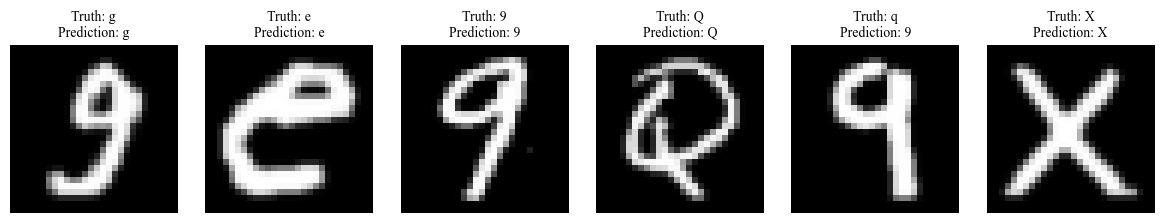

In [20]:
# Selecting the top samples from the testing dataset
num_samples_to_visualise = 6
sample_indices = range(num_samples_to_visualise)
samples = test_data.iloc[sample_indices]

# Visualising the samples and their predictions
fig, axes = plt.subplots(1, num_samples_to_visualise, figsize=(12, 3))
for i, (_, row) in enumerate(samples.iterrows()):
    label = row[0]
    image = row[1:].values.reshape(28, 28)
    # Flip left to right and rotate as before
    image = np.fliplr(image)
    image = np.rot90(image)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Truth: {mapping[label]}\nPrediction: {mapping[predicted_classes[i]]}", fontsize=10)
    axes[i].axis('off')
plt.tight_layout(pad=2.0)
plt.show()

#### 5.2.8. Printing the Confusion Matrix for the CNN Test (by label number)

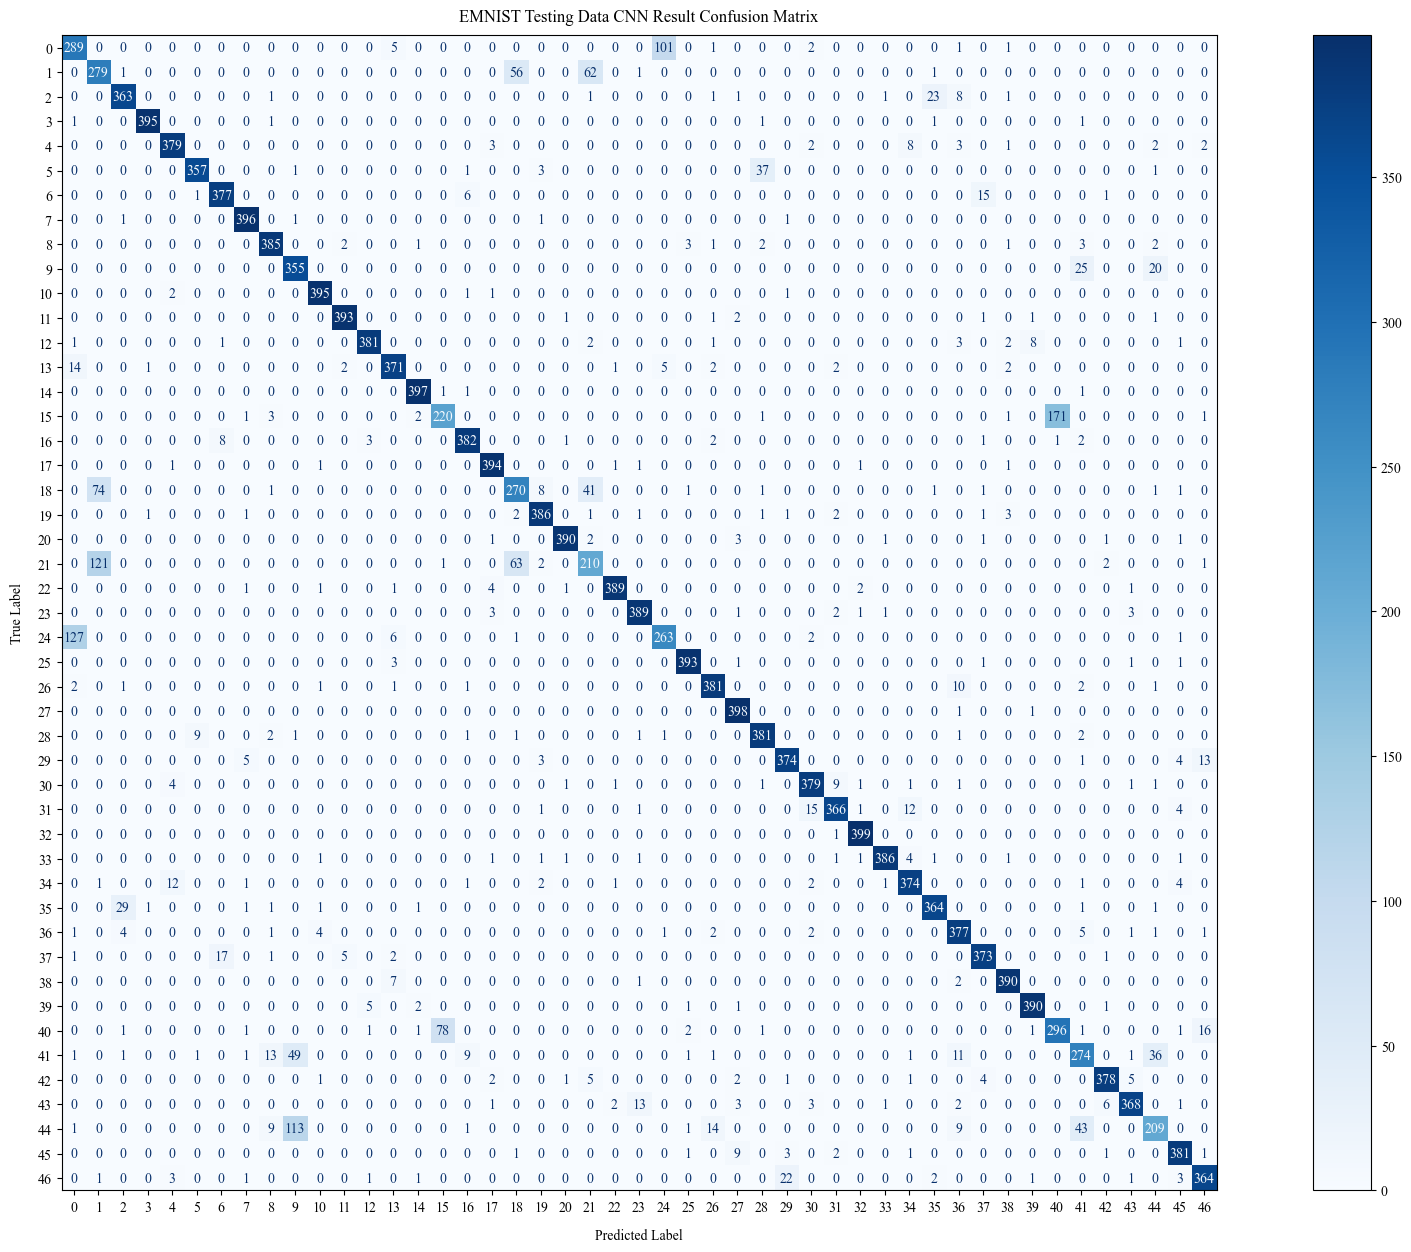

In [21]:
# Making the confusion matrix
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
fig, ax = plt.subplots(figsize=(25, 15))
cm_display.plot(cmap = plt.cm.Blues, ax=ax)
plt.title("EMNIST Testing Data CNN Result Confusion Matrix", pad='10')
plt.grid(False)

# Adding padding to x and y axis labels
ax.set_xlabel("Predicted Label", labelpad=10)
ax.set_ylabel("True Label", labelpad=10)

plt.show()

#### 5.2.9. Printing the Confusion Matrix for the CNN Test (by character)

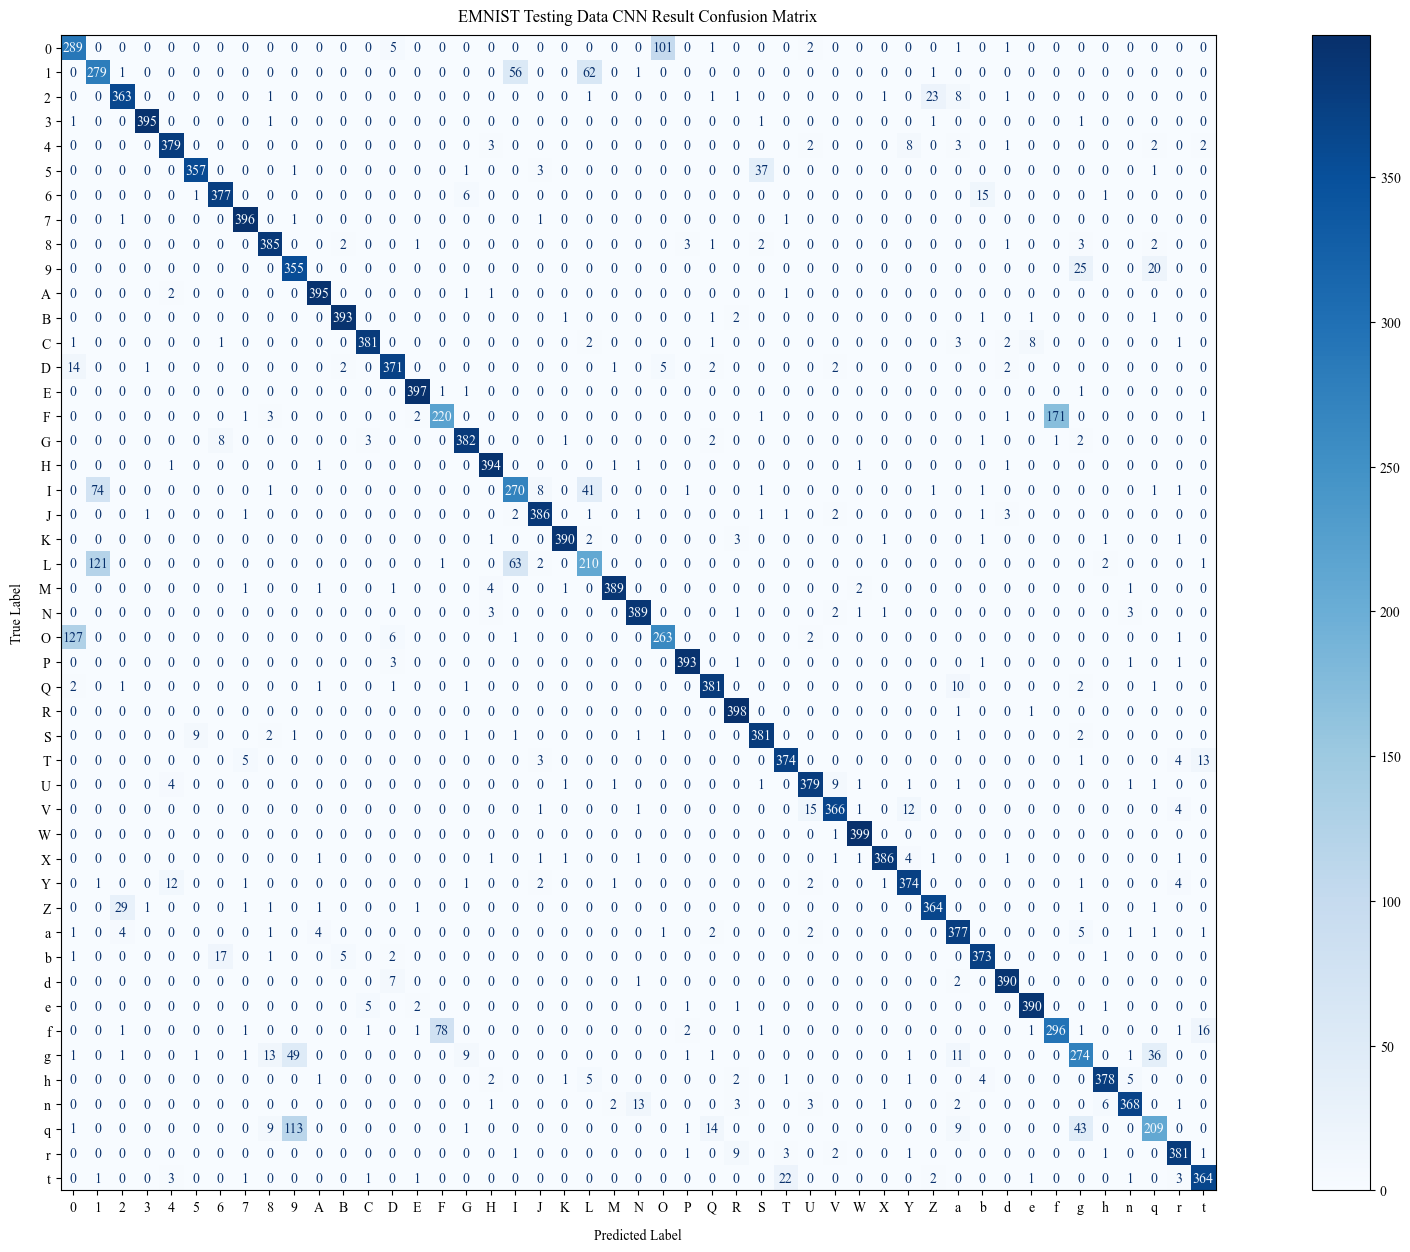

In [22]:
# Getting the characters for the axis labels
test_label_list = []
for key in mapping:
    test_label_list.append(mapping[key])

# Making the confusion matrix.
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=test_label_list)
fig, ax = plt.subplots(figsize=(25, 15))
cm_display.plot(cmap = plt.cm.Blues, ax=ax)
plt.title("EMNIST Testing Data CNN Result Confusion Matrix", pad='10')

# Adding padding to x and y axis labels
ax.set_xlabel("Predicted Label", labelpad=10)
ax.set_ylabel("True Label", labelpad=10)

plt.show()

#### 5.1.10. Reporting Recall, Accuracy and F1-score for the CNN Test

In [23]:
# Using Sklearn calculates the precision, recall and f1-score of the MLP
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

### 6.1. Comparing MLP and CNN Test Results

#### 6.1.1. Creating a DataFrame with the Evaluation Metrics for Each Model

In [42]:
# Defining a dictionary to store the performance metrics for each model
models = ['MLP', 'CNN']
metrics = ['acc', 'prec', 'recall', 'f1']
solutions = {
    'MLP': {'acc': accuracy_MLP/100, 'prec': precision_MLP, 'recall': recall_MLP, 'f1': f1_MLP},
    'CNN': {'acc': accuracy, 'prec': precision, 'recall': recall, 'f1': f1}
}

# A function to put the result of each performance metric for each model into a DataFrame
def plot_results(models, metrics):
    df = pd.DataFrame(index=models, columns=metrics)
    for model in models:
        for metric in metrics:
            df.loc[model, metric] = solutions[model][metric]
    return df

result_df = plot_results(models, metrics)
# Printing the evaluation metrics as a DataFrame
print(result_df)

          acc      prec    recall        f1
MLP  0.850319  0.855725  0.850319  0.851585
CNN  0.893617  0.894322  0.893617   0.89238


#### 6.1.2. Plotting the Evaluation Metrics for each Model

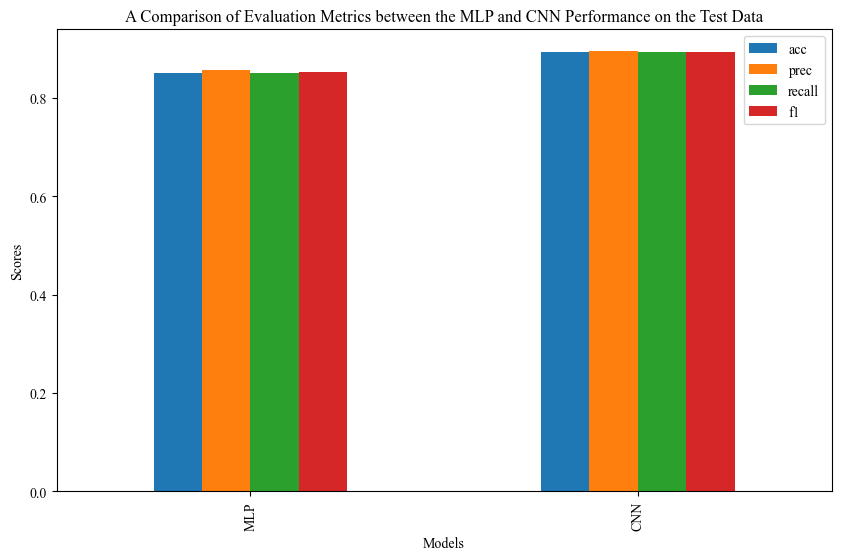

In [43]:
# Plotting the evaluation metrics
ax = result_df.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('A Comparison of Evaluation Metrics between the MLP and CNN Performance on the Test Data')

plt.show()